In [38]:
%matplotlib inline
from ecell4 import *
import numpy as np
import math
import matplotlib.pyplot as plt

k_factor = 10
voxelr = 0.005  
L = 350*voxelr
print 'L',L
D = 1
kd= 4.0*math.pi*D*2*voxelr
ka = k_factor*kd
kon = (ka*kd)/(ka+kd)
tm =(2*voxelr)**2/(6*D)
N = 4000
duration = -math.log(1e-10)/N/kon
dt=tm*10
w = spatiocyte.SpatiocyteWorld(ones()*L,voxelr)
Vr = w.calculate_volume(ones()*L,voxelr)
lx,ly,lz = tuple(w.calculate_shape(ones()*L,voxelr))
Nv = lx*ly*lz
vv = w.calculate_voxel_volume(voxelr)
phi = 2.*N/Nv
print 'Vr',Vr
print ka,kd,kon
print 'phi',phi*100,'phir',2*N*100*vv/Vr



L 1.75
Vr 5.48379976429
1.25663706144 0.125663706144 0.114239732858
phi 0.103155740411 phir 0.103155740411


0.0150122886138


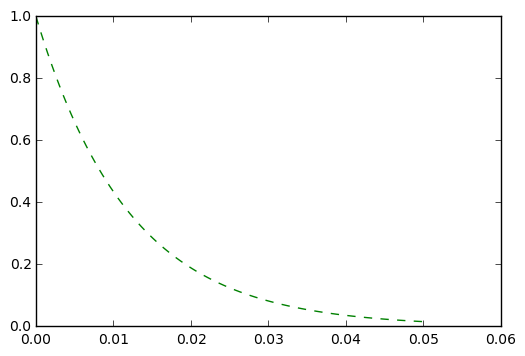

In [19]:
with reaction_rules():#for ODE
    A +B > B | kon

m1 = get_model()

ode = np.array(run_simulation(duration, model=m1, y0={'A': N,'B': N}, solver='ode', volume=Vr, return_type='array'))
to = ode[:,0]
nao = ode[:,1]
print nao[-1]/N
plt.plot(to,nao/N,'g--')

In [3]:
with species_attributes():
    A |  {'D': str(0), 'radius':str(voxelr)}
    B |  {'D': str(D), 'radius':str(voxelr)}

with reaction_rules():#for spa and egfrd
    A + B > B | ka

m2 = get_model()

def singlerun(i):
    rng = GSLRandomNumberGenerator()
    rng.seed(i)
    #w = spatiocyte.create_spatiocyte_world_cell_list_impl(ones() * L, voxelr, Integer3(3, 3, 3), rng)
    w = spatiocyte.SpatiocyteWorld(ones()*L,voxelr,rng)
    w.bind_to(m2)
    #ll= tuple(w.actual_lengths())
    #print ll[0]*ll[1]*ll[2]
    w.add_molecules(Species('A'), N)
    w.add_molecules(Species('B'), N)
    obs = FixedIntervalNumberObserver(dt, ('A'))
    sim = spatiocyte.SpatiocyteSimulator(w)
    sim.initialize()
    sim.run(duration, obs)    
    return np.array(obs.data())

def rungfrd(i):
    dtfactor = 1e6
    rng = GSLRandomNumberGenerator()
    rng.seed(i)
    mat = Integer3(1,1,1)*int(L/2/voxelr)
    #w = spatiocyte.create_spatiocyte_world_cell_list_impl(ones() * L, voxelr, Integer3(3, 3, 3), rng)
    w = egfrd.EGFRDWorld(Real3(L,L,L),matrix_sizes=mat,rng=rng)
    w.bind_to(m2)
    #ll= tuple(w.actual_lengths())
    #print ll[0]*ll[1]*ll[2]
    w.add_molecules(Species('A'), N)
    w.add_molecules(Species('B'), N)
    obs = FixedIntervalNumberObserver(dt, ('A'))
    sim = egfrd.EGFRDSimulator(w)
    #sim.set_dt(tm*dtfactor)
    sim.initialize()
    sim.run(duration, obs)    
    return np.array(obs.data())

In [4]:
def rung(run):   
    leng = int((duration/dt)+1)
    n = np.empty([run,leng])
    for i in range(run):
        spa = gfrd(i)
        n[i] = spa[:,1]        
    ts = spa[:,0]
    return ts,n

def rungtest(run):   
    spa = rungfrd(1)
    return spa[:,0]  ,spa[:,1]

def runspa(run):   
    leng = int((duration/dt)+1)
    n = np.empty([run,leng])
    for i in range(run):
        spa = singlerun(i)
        n[i] = spa[:,1]        
    ts = spa[:,0]
    return ts,n


In [5]:
run = 1000
#te,nae = rungtest(run)
#print len(te)
ts,nas = runspa(run)


In [6]:
mean = np.mean(nas,axis=0)
std = np.std(nas,axis=0)

[ 139.473  137.472  135.519  133.604  131.755  129.92   128.087  126.266
  124.491  122.757]


/usr/lib/python2.7/dist-packages/matplotlib/collections.py:571: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


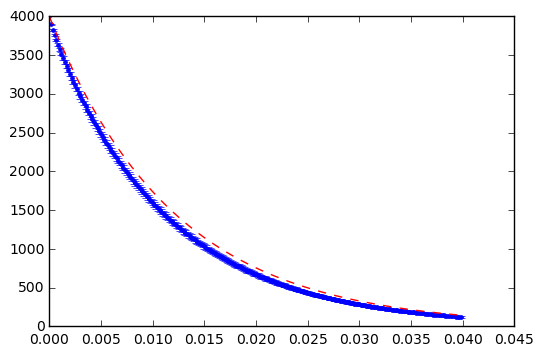

In [7]:
plt.errorbar(ts,mean,std,fmt=' ',marker='.')
plt.plot(to,nao,'r--')
print mean[-10:]

dt 0.000333333333333 1.66666666667e-05
29.6192195877
1.25663706144 0.114239732858 0.112113824389
0.114976165967


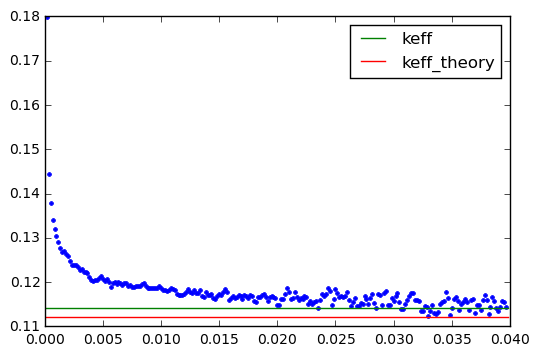

In [8]:
l=2
print 'dt',ts[l]-ts[0],tm
ks = -Vr *(mean[l:]-mean[:-l])/mean[:-l]/(ts[l]-ts[0])/N
plt.plot(ts[int(l*0.5):-int(l*0.5)],ks,'.')
Pacc = ka / (6 * math.sqrt(2) * D * voxelr)
print Pacc
r0=0.256318
kefftheory = 3*(2**0.5)*D*2*voxelr*(1/r0 -1)*Pacc/(Pacc+1/r0 -1)
plt.plot(ts,[kon]*len(ts),label='keff')
plt.plot(ts,[kefftheory]*len(ts),label='keff_theory')
plt.legend()
print ka,kon,kefftheory
km = np.mean(ks[-50:])
print km

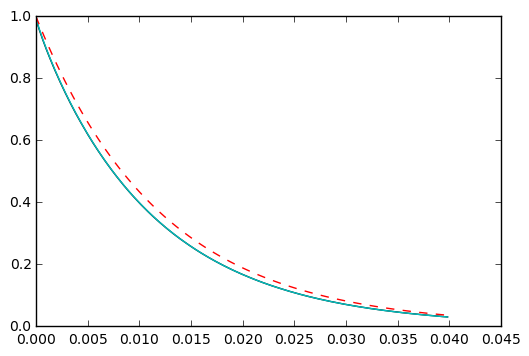

In [9]:
#C =1.02085
#r0=0.256318
#voxelr = 0.005/C
#kd = 4*np.pi*4*D*voxelr
#kaa = k_factor*4.0*math.pi*D*4*0.005
#ka = kaa*kd/(3*2**0.5 *D*4*0.005*(1/r0 -1))
#kon = (ka*kd)/(ka+kd)

#import scipy.integrate as integrate
def Phi(xx):
    return 1./( (377.*xx/324)+(1+ (314.*(xx**2)/847) )**0.5)

tau = ((ka*2*voxelr/(ka+kd))**2)/(D)
#tt= np.linspace(0,0.5,1e3)
#def kt(t):
#    x=ka*((t/tau)**(0.5))/kd
#    return kon*(1+(ka*phi(x)/kd))
#intkt = [integrate.quad(lambda t: kt(t),0,T)[0] for T in tt] 

tt=ts
intkt = [kon*(t+tau*((kd/ka)*(Phi(ka*((t/tau)**(0.5))/kd)-1)+2*(math.sqrt(t/np.pi/tau)))) for t in tt]

st = [math.exp(-ik*N/Vr) for ik in intkt]
#plt.errorbar(ts,mean/N,std/N,fmt=' ',marker='.')
plt.plot(ts,mean/N,'k')
plt.plot(tt,st,'c-')
plt.plot(to,nao/N,'r--')
#plt.ylim(0.4,1)

[ 11.318  11.302  11.278  11.266  11.238]
1.25663706144 0.114239732858 0.111905577215
0.115925889769 0.094007367079 0.137844412458
0.0219185226896
3.59259355365


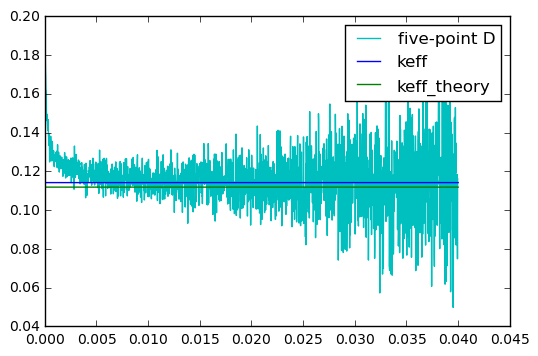

In [25]:
#ecell3 N1000, original P=0.05,run=500
import numpy as np
import math
dat = np.loadtxt('/home/chew/wrk/spatiocyte/examples/accuracy/3D_reaction/spatiocyte_3D_keff_N1k_P005.csv',delimiter=',',skiprows=1)
tc=dat[:,0]
mnac=dat[:,1]
print mnac[-5:]
k_factor = 10
voxelr = 0.005  
L = 200*voxelr
D = 1
kd= 4.0*math.pi*D*2*voxelr
ka = k_factor*kd
kon = (ka*kd)/(ka+kd)
w = spatiocyte.SpatiocyteWorld(ones()*L,voxelr)
Vr = w.calculate_volume(ones()*L,voxelr)
tc=dat[:,0]
mnac=dat[:,1]
l=2
N=1000
ks = -Vr *(mnac[l:]-mnac[:-l])/mnac[:-l]/(tc[l]-tc[0])/N
#plt.plot(tc[int(l*0.5):-int(l*0.5)],ks,'r-',label='two-point D')
s1=mnac[0:-5]
s2=mnac[1:-4]
s4=mnac[3:-2]
s5=mnac[4:-1]
ks2= (-Vr*(-s5+8*s4-8*s2+s1)/s1/N/12./tc[1]-tc[0])
plt.plot(tc[2:-3],ks2,'c-',label='five-point D')
r0=0.256318
Pacc= (1./r0-1)*ka/kd
kefftheory = 3*(2**0.5)*D*2*voxelr*(1/r0 -1)*Pacc/(Pacc+1/r0 -1)
plt.plot(tc,[kon]*len(tc),label='keff')
plt.plot(tc,[kefftheory]*len(tc),label='keff_theory')
plt.legend()
print ka,kon,kefftheory
lp = 200
kstd=np.std(ks[-lp:])
km = np.mean(ks[-lp:])
print km,km-kstd,km+kstd
print kstd
print (km-kefftheory)*100/kefftheory
#plt.ylim([0.11,0.19])
#print tc[-lp]

[ 55.50005     55.42574257  55.35453545  55.27672767  55.19661966]
(2999,) (2999,)
ka,kon,kefftheory
1.25663706144 0.114239732858 0.112113824389


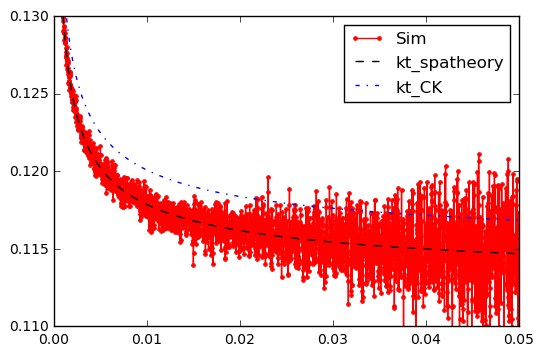

In [30]:
#original, cluster, trials=1e4, alpha=0.1,manual logging
%matplotlib inline
from ecell4 import *
import numpy as np
import math
import matplotlib.pyplot as plt
dat = np.loadtxt('kfac10a01cmeanNa',delimiter=',')

tc=dat[:,0]
mnac=dat[:,1]
print mnac[-5:]

k_factor = 10
voxelr = 0.005  
L = 350*voxelr
D = 1
kd= 4.0*math.pi*D*2*voxelr
ka = k_factor*kd
kon = (ka*kd)/(ka+kd)
tm =(2*voxelr)**2/(6*D)
N = 4000
duration = -math.log(1e-10)/N/kon
dt=tm*10
w = spatiocyte.SpatiocyteWorld(ones()*L,voxelr)
Vr = w.calculate_volume(ones()*L,voxelr)

def getkt2(st,t): #two-point
    ks = -Vr *(st[2:]-st[:-2])/st[:-2]/(t[2]-t[0])/N
    return ks

def getkt5(st,t): #five-point
    s1=st[0:-5]
    s2=st[1:-4]
    s4=st[3:-2]
    s5=st[4:-1]
    ks2= (-Vr*(-s5+8*s4-8*s2+s1)/s1/N/12./t[1]-t[0])
    return ks2
print mnac.shape,tc.shape
ks = getkt2(mnac,tc)
plt.plot(tc[1:-1],ks,'r.-',label='Sim')

#plt.plot(tc[2:-3],ks2,'c-',label='five-point D')
r0=0.256318
Pacc= ka/3/2**0.5/D/2/voxelr
kdd = 3*(2**0.5)*D*2*voxelr*(1/r0 -1)
kefftheory = kdd*Pacc/(Pacc+1/r0 -1)
#plt.plot(tc,[kon]*len(tc),label='keff')
#plt.plot(tc,[kefftheory]*len(tc),label='keff_theory')
print 'ka,kon,kefftheory'
print ka,kon,kefftheory
#lp = 200
#kstd=np.std(ks[-lp:])
#km = np.mean(ks[-lp:])
#print km,km-kstd,km+kstd
#print kstd
#print (km-kefftheory)*100/kefftheory
#print tc[-lp]

def Phi(xx):
    return 1./( (377.*xx/324)+(1+ (314.*(xx**2)/847) )**0.5)

def getktt(ka,kdd,rm,tc):
    tau = ((ka*2*rm/(ka+kdd))**2)/(D)
    kt1 = [(ka*kdd/(ka+kdd))*(1+(ka/kdd)*Phi(ka*(t/tau)**0.5 /kdd)) for t in tc]
    return kt1

kt1 = getktt(ka,kdd,voxelr,tc)
kt2 = getktt(ka,kd,voxelr,tc)
plt.plot(tc,kt1,'k--',label='kt_spatheory')
plt.plot(tc,kt2,'b-.',label='kt_CK')
#plt.xlim([0.09,0.1])
plt.ylim([0.11,0.13])
plt.legend()

In [31]:
ll=-600
ksm = np.mean(ks[1:-1][ll:])
kt1m = np.mean(kt1[1:-1][ll:])
kt2m = np.mean(kt2[1:-1][ll:])
print (ksm-kt1m)*100/kt1m,(ksm-kt2m)*100/kt2m

0.0732934153329 -1.78466613924


In [40]:
print ks[:5]
print ks2[:5]

[ 0.21315808  0.19061698  0.18045932  0.17346677  0.1681701 ]
[ 0.09398308  0.08972773  0.08637761  0.08375501  0.08199956]


0.026
[ 55.88858886  55.81118112  55.73237324  55.65326533  55.57855786  55.50005
  55.42574257  55.35453545  55.27672767  55.19661966]


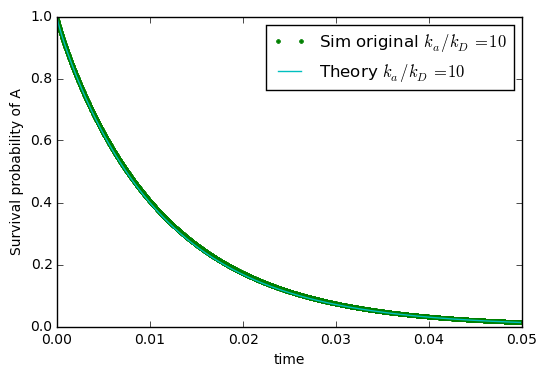

In [37]:
rm=voxelr
tau = ((ka*2*rm/(ka+kd))**2)/(D)
T=np.arange(0,0.05,tm*10)
intkt = [kon*(t+tau*((kd/ka)*(Phi(ka*((t/tau)**(0.5))/kd)-1)+2*(math.sqrt(t/np.pi/tau)))) for t in T]

st = np.array([math.exp(-ik*N/Vr) for ik in intkt])
print T[st<0.1][0]
#plt.plot(tt[::40],(mna/N)[::40],'r.',label='Sim original $k_a/k_D=0.1$')
plt.plot(tc[::1],(mnac/N)[::1],'g.',label='Sim original $k_a/k_D=10$')
plt.plot(T,st,'c-',label='Theory $k_a/k_D=10$')
plt.legend(loc='best')
plt.ylabel('Survival probability of A')
plt.xlabel('time')
print mnac[-10:]
#plt.savefig("figure/survival_probability_ori_correct_theory.png",format='png',dpi=300)    

0.112113824389
[ 55.88858886  55.81118112  55.73237324  55.65326533  55.57855786  55.50005
  55.42574257  55.35453545  55.27672767  55.19661966]


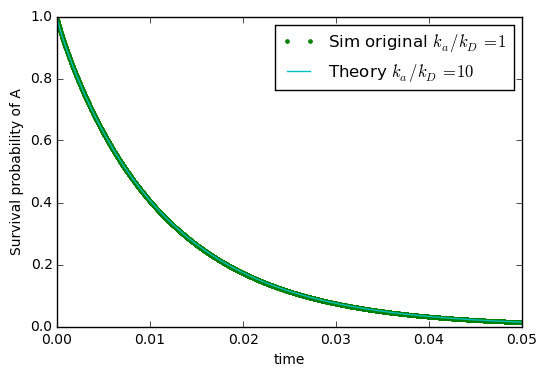

In [76]:
def Phi(xx):
    return 1./( (377.*xx/324)+(1+ (314.*(xx**2)/847) )**0.5)
rm=voxelr
tau = ((ka*2*rm/(ka+kd))**2)/(D)
T=np.arange(0,0.05,tm*0.5)
kd = 3*(2**0.5)*D*2*voxelr*(1/r0 -1)
print ka*kd/(ka+kd)
kon = 0.111905577215
intkt = [kon*(t+tau*((kd/ka)*(Phi(ka*((t/tau)**(0.5))/kd)-1)+2*(math.sqrt(t/np.pi/tau)))) for t in T]

st = np.array([math.exp(-ik*N/Vr) for ik in intkt])

#plt.plot(tt[::40],(mna/N)[::40],'r.',label='Sim original $k_a/k_D=0.1$')
plt.plot(tc[::1],(mnac/N)[::1],'g.',label='Sim original $k_a/k_D=1$')
plt.plot(T,st,'c-',label='Theory $k_a/k_D=10$')
plt.legend(loc='best')
plt.ylabel('Survival probability of A')
plt.xlabel('time')
print mnac[-10:]
#plt.savefig("figure/survival_probability_ori_correct_theory.png",format='png',dpi=300)    

0.114472622287
0.11439321057


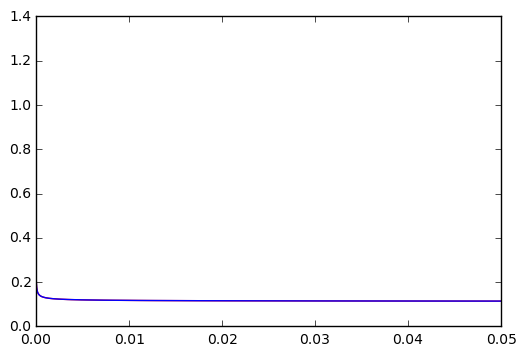

In [78]:
kt = [kon*(1+(ka/kd)*Phi(ka*(t/tau)**0.5 /kd)) for t in T]
ks = -Vr *(st[2:]-st[:-2])/st[:-2]/(T[2]-T[0])/N
s1=st[0:-5]
s2=st[1:-4]
s4=st[3:-2]
s5=st[4:-1]
ks2= (-Vr*(-s5+8*s4-8*s2+s1)/s1/N/12./T[1]-T[0])
#plt.plot(T[2:-3],ks2,'c-',label='five-point D')
print kt[-1]
print ks[-1]
#print ks2[-1]
plt.plot(T[1:-1],ks,'r-',label='two-point D')
plt.plot(T,kt)
#plt.ylim(0.116,0.125)

L 1.75 Vr 5.48853618685
ka,kon,kefftheory
1.25663706144 0.114239732858 0.114254152202
0.0126220047564


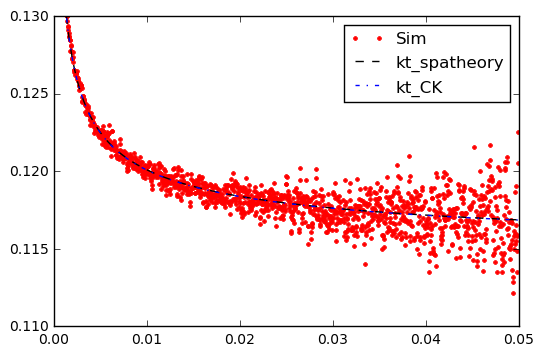

In [63]:
#corrected, cluster, trials=, alpha=0.1,manual logging
%matplotlib inline
from ecell4 import *
import numpy as np
import math
import matplotlib.pyplot as plt
dat = np.loadtxt('kfacc10.0a01meanNar10k',delimiter=',')
lg=2
tc=dat[:,0][::lg]
mnac=dat[:,1][::lg]

k_factor = 10
f=1.021
rm = 0.005  
voxelr=f*rm
L = 1.75#350*voxelr
D = 1
kd= 4.0*math.pi*D*2*rm
ka = k_factor*kd
kon = (ka*kd)/(ka+kd)
tm =(2*voxelr)**2/(6*D)
N = 4000
w = spatiocyte.SpatiocyteWorld(ones()*L,voxelr)
Vr = w.calculate_volume(ones()*L,voxelr)
print 'L',L,'Vr',Vr
def getkt2(st,t): #two-point
    ks = -Vr *(st[2:]-st[:-2])/st[:-2]/(t[2]-t[0])/N
    return ks

def getkt5(st,t): #five-point
    s1=st[0:-5]
    s2=st[1:-4]
    s4=st[3:-2]
    s5=st[4:-1]
    ks2= (-Vr*(-s5+8*s4-8*s2+s1)/s1/N/12./t[1]-t[0])
    return ks2

ks = getkt2(mnac,tc)
plt.plot(tc[1:-1],ks,'r.',label='Sim')

#plt.plot(tc[2:-3],ks2,'c-',label='five-point D')
r0=0.256318
Pacc= ka/3/2**0.5/D/2/voxelr
kdd = 3*(2**0.5)*D*2*voxelr*(1/r0 -1)
kefftheory = kdd*Pacc/(Pacc+1/r0 -1)
#plt.plot(tc,[kon]*len(tc),label='keff')
#plt.plot(tc,[kefftheory]*len(tc),label='keff_theory')
print 'ka,kon,kefftheory'
print ka,kon,kefftheory
#lp = 200
#kstd=np.std(ks[-lp:])
#km = np.mean(ks[-lp:])
#print km,km-kstd,km+kstd
#print kstd
#print (km-kefftheory)*100/kefftheory
#print tc[-lp]

def Phi(xx):
    return 1./( (377.*xx/324)+(1+ (314.*(xx**2)/847) )**0.5)

def getktt(ka,kdd,rm,tc):
    tau = ((ka*2*rm/(ka+kdd))**2)/(D)
    kt1 = [(ka*kdd/(ka+kdd))*(1+(ka/kdd)*Phi(ka*(t/tau)**0.5 /kdd)) for t in tc]
    return kt1

kt1 = getktt(ka,kdd,rm,tc)
kt2 = getktt(ka,kd,rm,tc)
plt.plot(tc,kt1,'k--',label='kt_spatheory')
plt.plot(tc,kt2,'b-.',label='kt_CK')
#plt.xlim([0,0.005])
plt.ylim([0.11,0.13])
plt.legend()
np.mean(ks[-100:])
print (kefftheory-kon)*100/kon

In [61]:
ll=-600
ksm = np.mean(ks[1:-1][ll:])
kt1m = np.mean(kt1[1:-1][ll:])
kt2m = np.mean(kt2[1:-1][ll:])
print (ksm-kt1m)*100/kt1m,(ksm-kt2m)*100/kt2m

-0.078441140821 -0.0658610361968


0.112113824389
[ 65.92   65.748  65.561  65.366  65.186  65.01   64.817  64.62   64.436
  64.258]


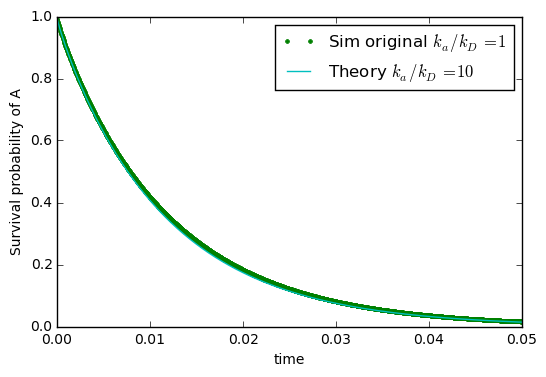

In [46]:
def Phi(xx):
    return 1./( (377.*xx/324)+(1+ (314.*(xx**2)/847) )**0.5)
rm=voxelr
tau = ((ka*2*rm/(ka+kd))**2)/(D)
T=np.arange(0,0.05,tm*0.5)
kd = 3*(2**0.5)*D*2*voxelr*(1/r0 -1)
print ka*kd/(ka+kd)
kon = 0.111905577215
intkt = [kon*(t+tau*((kd/ka)*(Phi(ka*((t/tau)**(0.5))/kd)-1)+2*(math.sqrt(t/np.pi/tau)))) for t in T]

st = np.array([math.exp(-ik*N/Vr) for ik in intkt])

#plt.plot(tt[::40],(mna/N)[::40],'r.',label='Sim original $k_a/k_D=0.1$')
plt.plot(tc[::1],(mnac/N)[::1],'g.',label='Sim original $k_a/k_D=1$')
plt.plot(T,st,'c-',label='Theory $k_a/k_D=10$')
plt.legend(loc='best')
plt.ylabel('Survival probability of A')
plt.xlabel('time')
print mnac[-10:]
#plt.savefig("figure/survival_probability_ori_correct_theory.png",format='png',dpi=300)    

In [35]:
def out(voxelr):
    r0=0.256318
    Pacc= ka/3/2**0.5/D/2/voxelr
    kdd = 3*(2**0.5)*D*2*voxelr*(1/r0 -1)
    kefftheory = kdd*Pacc/(Pacc+1/r0 -1)
    return kefftheory
out(voxelr),out(voxelr*1.021),kon

(0.11211382438865652, 0.11425415220232567, 0.11423973285781067)